In [1]:
import pandas, matplotlib.pyplot as plt, numpy, scipy.interpolate, scipy.optimize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

# Contour Plots

In [2]:
def contour(I):
    start,stop = I
    df = pandas.read_excel('2kRuns.xlsx')
    freq = df.Frequency.values.flatten()[start:stop]
    speed = df.Roller_speed.values.flatten()[start:stop]
    dia = numpy.abs( 1.75 - df.Ave_D.values.flatten()[start:stop])

    Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
    Freq, Speed = numpy.meshgrid(Freq, Speed)

    Dia = scipy.interpolate.griddata( (freq,speed), dia, (Freq,Speed))

    C = plt.contourf(Freq, Speed, Dia, numpy.arange(0,0.3,0.03))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Difference between diameter and setpoint (mm)')
    plt.ylabel('Pinch roller motor speed (units on HMI)')
    plt.xlabel('Extruder frequency (Hz)')
    plt.plot(freq,speed,'ro')
    plt.show()
    
def contour_bubbles(I,name):
    start,stop = I
    df = pandas.read_excel('2kRuns.xlsx')
    freq = df.Frequency.values.flatten()[start:stop]
    speed = df.Roller_speed.values.flatten()[start:stop]
    bub = df.Bubbles_per_m.values.flatten()[start:stop]

    Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
    Freq, Speed = numpy.meshgrid(Freq, Speed)

    Bub = scipy.interpolate.griddata( (freq,speed), bub, (Freq,Speed))
    
    fig = plt.figure()
    C = plt.contourf(Freq, Speed, Bub,numpy.arange(0,11,1))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Bubbles per m filament')
    plt.ylabel('Pinch roller motor speed (units on HMI)')
    plt.xlabel('Extruder frequency (Hz)')
    plt.plot(freq,speed,'ro')
    plt.show()
    plt.draw()
    fig.savefig('bubbles'+name+'.svg')

A = [0,9]
B = [9,18]

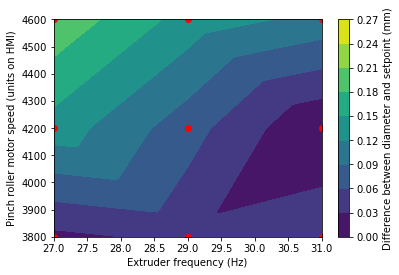

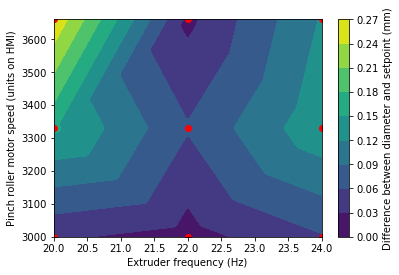

In [3]:
contour(A) 
contour(B)

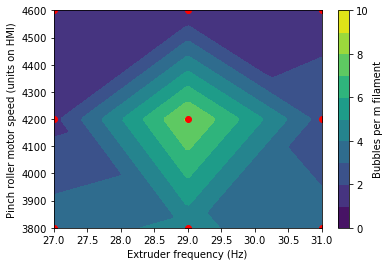

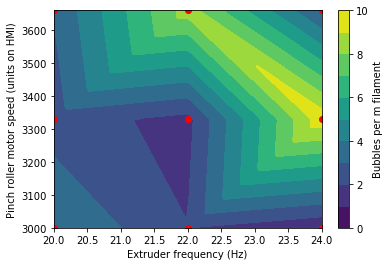

In [4]:
contour_bubbles(A,'A') 
contour_bubbles(B,'B')

# Data surface plots

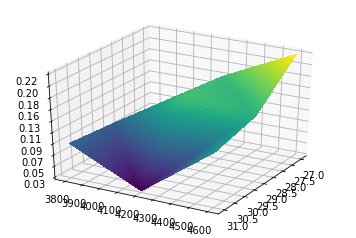

In [5]:
def surface(I):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    start,stop = I
    df = pandas.read_excel('2kRuns.xlsx')
    freq = df.Frequency.values.flatten()[start:stop]
    speed = df.Roller_speed.values.flatten()[start:stop]
    dia = numpy.abs( 1.75 - df.Ave_D.values.flatten()[start:stop])
    bub = df.Bubbles_per_m.values.flatten()[start:stop]
    
    z = dia + 0.1/9 * bub
    
    

    Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
    Freq, Speed = numpy.meshgrid(Freq, Speed)

    Z = scipy.interpolate.griddata( (freq,speed), z, (Freq,Speed))

    S = ax.plot_surface(Freq, Speed, Z, cmap=cm.viridis, linewidth=0, antialiased=False)


    ax.view_init(30, 30)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
#     fig.colorbar(mappable)

    plt.show()
    
surface(A)

# Fit surface plot

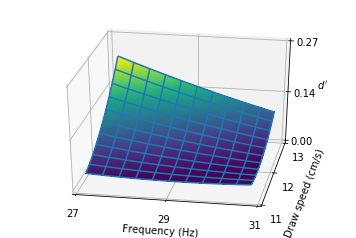

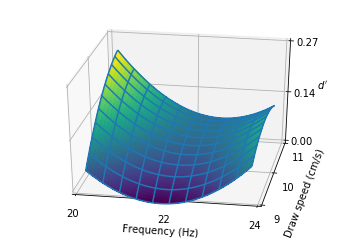

(None, None)

In [6]:
def quadratic(I,name):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    start,stop = I
    df = pandas.read_excel('2kRuns.xlsx')
    freq = df.Frequency.values.flatten()[start:stop]
    speed = df.Roller_speed.values.flatten()[start:stop]*0.0029
    dia = numpy.abs( 1.75 - df.Ave_D.values.flatten()[start:stop])
    bub = df.Bubbles_per_m.values.flatten()[start:stop]
    
    weight = 0
    z = dia + weight * bub
    
    xdata = numpy.vstack((freq,speed))
    def surface_fit(xdata, beta0,beta1,beta2,beta12,beta11,beta22,eps):
        freq,speed = xdata
        x1 = freq
        x2 = speed
        return beta0 + beta1*x1 + beta2*x2 + beta12*x1*x2 + beta11*x1**2 + beta22*x2**2 + eps

    beta, _ = scipy.optimize.curve_fit(surface_fit, xdata, z, list(numpy.zeros(7)))
    beta0,beta1,beta2,beta12,beta11,beta22,eps = beta



    Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
    Freq, Speed = numpy.meshgrid(Freq, Speed)

    def surface_equation(Freq,Speed, beta0,beta1,beta2,beta12,beta11,beta22,eps):
        x1 = Freq
        x2 = Speed
        return beta0 + beta1*x1 + beta2*x2 + beta12*x1*x2 + beta11*x1**2 + beta22*x2**2 + eps


    Z = surface_equation(Freq,Speed, beta0,beta1,beta2,beta12,beta11,beta22,eps)

    S = ax.plot_surface(Freq, Speed, Z, cmap=cm.viridis, linewidth=0, antialiased=False)
    S2 = ax.plot_wireframe(Freq, Speed, Z, rstride=10, cstride=10)

    ax.view_init(30, 280)
    ax.zaxis.set_major_locator(LinearLocator(3))
    ax.yaxis.set_major_locator(LinearLocator(3))
    ax.set_ylabel('Draw speed (cm/s)', linespacing=3.1)
    ax.set_xlabel('Frequency (Hz)', linespacing=3.1)
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel('$d\'$',rotation=0)
    ax.xaxis.set_major_locator(LinearLocator(3))
    ax.set_zlim3d(0,0.27)
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    plt.show()
    plt.draw()
    name = 'quadratic'+str(name)+'.svg'
    fig.savefig(name)

quadratic(A,'A'), quadratic(B,'B')

# Motor frequency vs filament volumetric flow rate

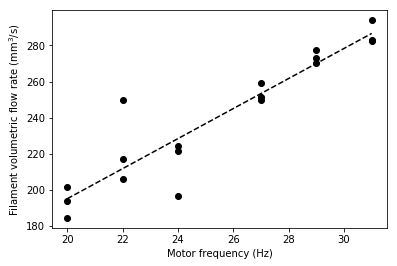

In [17]:
df = pandas.read_excel('2kRuns.xlsx')
freq = df.Frequency.values.flatten()
cmps = df.Roller_speed_cmps.values.flatten()
dia_actual = df.Ave_D.values.flatten()

Q = numpy.pi/4 * (dia_actual)**2 * cmps*10

Qfit = numpy.polyfit(freq,Q, 1)
Qmodel = numpy.poly1d(Qfit)

fig17 = plt.figure()
plt.plot(freq,Q,'ko')
plt.plot(numpy.sort(freq), Qmodel(numpy.sort(freq)),'k--')
plt.xlabel('Motor frequency (Hz)')
plt.ylabel('Filament volumetric flow rate (mm$^3$/s)')
plt.show()
plt.draw()

fig17.savefig('massabalans.svg')

In [8]:
numpy.poly1d(Qfit)

poly1d([  8.31314771,  28.90480632])

# Optimisation line

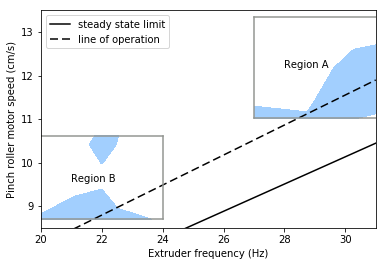

In [16]:
figura = plt.figure()

I = A 
start,stop = I
df = pandas.read_excel('2kRuns.xlsx')
freq = df.Frequency.values.flatten()[start:stop]
speed = df.Roller_speed.values.flatten()[start:stop]*0.0029
dia = numpy.abs( 1.75 - df.Ave_D.values.flatten()[start:stop])

Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
Freq, Speed = numpy.meshgrid(Freq, Speed)

Dia = scipy.interpolate.griddata( (freq,speed), dia, (Freq,Speed))

C1 = plt.contourf(Freq, Speed, Dia, numpy.arange(0,0.06,0.05),colors='xkcd:baby blue')

I = B 
start,stop = I
df = pandas.read_excel('2kRuns.xlsx')
freq = df.Frequency.values.flatten()[start:stop]
speed = df.Roller_speed.values.flatten()[start:stop]*0.0029
dia = numpy.abs( 1.75 - df.Ave_D.values.flatten()[start:stop])

Freq, Speed = numpy.linspace( freq.min(), freq.max(), 100) , numpy.linspace( speed.min(), speed.max(), 100)
Freq, Speed = numpy.meshgrid(Freq, Speed)

Dia = scipy.interpolate.griddata( (freq,speed), dia, (Freq,Speed))

C2 = plt.contourf(Freq, Speed, Dia, numpy.arange(0,0.06,0.05),colors='xkcd:baby blue', label='hi')

plt.ylabel('Pinch roller motor speed (cm/s)')
plt.xlabel('Extruder frequency (Hz)')

# Steady state limit

a = 108
b = -1
c = 254

freq = df.Frequency.values.flatten()
freq = numpy.sort(freq)

plt.plot(freq,(a*freq+c)*0.0029,'k',label='steady state limit')
plt.plot(freq,(119*freq+414)*0.0029,'k', label='line of operation',dashes=[4,2]) # Model line
plt.legend(loc=2)

plt.text(21,3300*0.0029,'Region B')
plt.text(28,4200*0.0029,'Region A')

plt.plot([20,24],[3660*0.0029,3660*0.0029],'xkcd:grey')
plt.plot([20,24],[3000*0.0029,3000*0.0029],'xkcd:grey')
plt.plot([24,24],[3000*0.0029,3660*0.0029],'xkcd:grey')
plt.plot([27,31],[3800*0.0029,3800*0.0029],'xkcd:grey')
plt.plot([27,31],[4600*0.0029,4600*0.0029],'xkcd:grey')
plt.plot([27,27],[4600*0.0029,3800*0.0029],'xkcd:grey')

plt.ylim(8.5,13.5)
plt.show()
plt.draw()
figura.savefig('mbmodel.png')   